In [ ]:
#default_exp foundation

In [ ]:
#export
from fastcore.imports import *

In [ ]:
from fastcore.test import *
from nbdev.showdoc import *

# Core

> Basic functions used in the fastai library

In [ ]:
# export
defaults = SimpleNamespace()

## Metaclasses

See this [blog post](https://realpython.com/python-metaclasses/) for more information about metaclasses. 
- `PrePostInitMeta` ensures that the classes defined with it run `__pre_init__` and `__post_init__` (without having to write `self.__pre_init__()` and `self.__post_init__()`  in the actual `init`
- `NewChkMeta` gives the `PrePostInitMeta` functionality and ensures classes defined with it don't re-create an object of their type whenever it's passed to the constructor
- `BypassNewMeta` ensures classes defined with it can easily be casted form objects they subclass.

In [ ]:
#export 
def _rm_self(sig):
    sigd = dict(sig.parameters)
    sigd.pop('self')
    return sig.replace(parameters=sigd.values())

In [ ]:
#export
class FixSigMeta(type):
    "A metaclass that fixes the signature on classes that override __new__"
    def __new__(cls, name, bases, dict):
        res = super().__new__(cls, name, bases, dict)
        if res.__init__ is not object.__init__: res.__signature__ = _rm_self(inspect.signature(res.__init__))
        return res

When you inherit from a class that defines `__new__`, or a metaclass that defines `__call__`, the signature of your `__init__` method is obfuscated such that tab completion no longer works.  `FixSigMeta` fixes this issue and restores signatures.

#### Example

You can inspect the signature of an object with `inspect.signature`:

In [ ]:
class T:
    def __init__(self, a, b, c): pass
    
inspect.signature(T)

<Signature (a, b, c)>

This corresponds to tab completion working in the normal way:

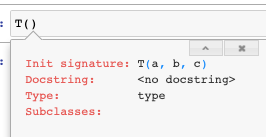

However, when you inherhit from a class that defines `__new__` or a metaclass that defines `__call__` this obfuscates the signature by overriding your class with the signature of `__new__`, which prevents tab completion from displaying useful information:

In [ ]:
class Foo:
    def __new__(self, **args): pass

class Bar(Foo):
    def __init__(self, d, e, f): pass
    
inspect.signature(Bar)

<Signature (**args)>

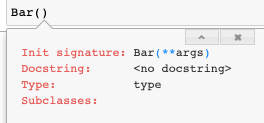

Finally, the signature and tab completion can be restored by inheriting from the metaclass `FixSigMeta` as shown below:

In [ ]:
class Bar(Foo, metaclass=FixSigMeta):
    def __init__(self, d, e, f): pass
    
test_sig(Bar, '(d, e, f)')
inspect.signature(Bar)

<Signature (d, e, f)>

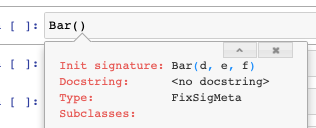

If you need to define a metaclass that overrides `__call__` (as done in `PrePostInitMeta`), you need to inherit from `FixSigMeta` instead of `type` when constructing the metaclass to preserve the signature in `__init__`.  Be careful not to override `__new__` when doing this:

In [ ]:
class TestMeta(FixSigMeta):
    # __new__ comes from FixSigMeta
    def __call__(cls, *args, **kwargs): pass
    
class T(metaclass=TestMeta):
    def __init__(self, a, b): pass
    
test_sig(T, '(a, b)')

On the other hand, if you fail to inherit from `FixSigMeta` when inheriting from a metaclass that overrides `__call__`, your signature will reflect that of `__call__` instead (which is often undesirable):

In [ ]:
class GenericMeta(type):
    "A boilerplate metaclass that doesn't do anything for testing."
    def __new__(cls, name, bases, dict):
        return super().__new__(cls, name, bases, dict)
    def __call__(cls, *args, **kwargs): pass

class T2(metaclass=GenericMeta):
    def __init__(self, a, b): pass

# We can avoid this by inheriting from the metaclass `FixSigMeta`
test_sig(T2, '(*args, **kwargs)')

In [ ]:
#export
class PrePostInitMeta(FixSigMeta):
    "A metaclass that calls optional `__pre_init__` and `__post_init__` methods"
    def __call__(cls, *args, **kwargs):
        res = cls.__new__(cls)
        if type(res)==cls:
            if hasattr(res,'__pre_init__'): res.__pre_init__(*args,**kwargs)
            res.__init__(*args,**kwargs)
            if hasattr(res,'__post_init__'): res.__post_init__(*args,**kwargs)
        return res

In [ ]:
show_doc(PrePostInitMeta, title_level=3)

<h3 id="PrePostInitMeta" class="doc_header"><code>class</code> <code>PrePostInitMeta</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>PrePostInitMeta</code>(**`name`**, **`bases`**, **`dict`**) :: [`FixSigMeta`](/foundation.html#FixSigMeta)

A metaclass that calls optional `__pre_init__` and `__post_init__` methods

In [ ]:
class _T(metaclass=PrePostInitMeta):
    def __pre_init__(self):  self.a  = 0; assert self.a==0
    def __init__(self,b=0):  self.a += 1; assert self.a==1
    def __post_init__(self): self.a += 1; assert self.a==2

t = _T()
test_eq(t.a, 2)

In [ ]:
#export
class NewChkMeta(FixSigMeta):
    "Metaclass to avoid recreating object passed to constructor"
    def __call__(cls, x=None, *args, **kwargs):
        if not args and not kwargs and x is not None and isinstance(x,cls):
            x._newchk = 1
            return x

        res = super().__call__(*((x,) + args), **kwargs)
        res._newchk = 0
        return res

In [ ]:
class _T(metaclass=NewChkMeta):
    "Testing"
    def __init__(self, o=None, b=1):
        self.foo = getattr(o,'foo',0) + 1
        self.b = b

In [ ]:
class _T2():
    def __init__(self, o): self.foo = getattr(o,'foo',0) + 1

t = _T(1)
test_eq(t.foo,1)

t2 = _T(t)
test_eq(t2.foo,1)
test_is(t,t2)

t3 = _T(t, b=2)
test_eq(t3.b, 2)
assert not t3 is t

t = _T2(1)
test_eq(t.foo,1)
t2 = _T2(t)
test_eq(t2.foo,2)

test_eq(_T.__doc__, "Testing")
test_eq(str(inspect.signature(_T)), '(o=None, b=1)')

In [ ]:
#export
class BypassNewMeta(FixSigMeta):
    "Metaclass: casts `x` to this class if it's of type `cls._bypass_type`, initializing with `_new_meta` if available"
    def __call__(cls, x=None, *args, **kwargs):
        if hasattr(cls, '_new_meta'): x = cls._new_meta(x, *args, **kwargs)
        elif not isinstance(x,getattr(cls,'_bypass_type',object)) or len(args) or len(kwargs):
            x = super().__call__(*((x,)+args), **kwargs)
        if cls!=x.__class__: x.__class__ = cls
        return x

In [ ]:
class T0: pass
class _T(T0, metaclass=BypassNewMeta):
    _bypass_type=T0
    def __init__(self,x): self.x=x

t = T0()
t.a = 1
t2 = _T(t)
test_eq(type(t2), _T)
test_eq(t2.a,1)
test_is(t2,t)
t = _T(2)
t.x = 2

## Foundational functions

In [ ]:
#export
def copy_func(f):
    "Copy a non-builtin function (NB `copy.copy` does not work for this)"
    if not isinstance(f,FunctionType): return copy(f)
    fn = FunctionType(f.__code__, f.__globals__, f.__name__, f.__defaults__, f.__closure__)
    fn.__dict__.update(f.__dict__)
    return fn

In [ ]:
#export
def patch_to(cls, as_prop=False, cls_method=False):
    "Decorator: add `f` to `cls`"
    if not isinstance(cls, (tuple,list)): cls=(cls,)
    def _inner(f):
        for c_ in cls:
            nf = copy_func(f)
            # `functools.update_wrapper` when passing patched function to `Pipeline`, so we do it manually
            for o in functools.WRAPPER_ASSIGNMENTS: setattr(nf, o, getattr(f,o))
            nf.__qualname__ = f"{c_.__name__}.{f.__name__}"
            if cls_method:
                setattr(c_, f.__name__, MethodType(nf, c_))
            else:
                setattr(c_, f.__name__, property(nf) if as_prop else nf)
        return f
    return _inner

In [ ]:
class _T3(int): pass

@patch_to(_T3)
def func1(x, a): return x+a

@patch_to(_T3, cls_method=True)
def from_func2(cls, a): return cls(a)

t = _T3(1)
test_eq(t.func1(2), 3)

t2 = _T3(2)
test_eq(t2, 2)

If `cls` is a tuple, `f` is added to all types in the tuple.

In [ ]:
class _T4(int): pass
@patch_to((_T3,_T4))
def func2(x, a): return x+2*a

t = _T3(1)
test_eq(t.func2(1), 3)
t = _T4(1)
test_eq(t.func2(1), 3)

In [ ]:
#export
def patch(f):
    "Decorator: add `f` to the first parameter's class (based on f's type annotations)"
    cls = next(iter(f.__annotations__.values()))
    return patch_to(cls)(f)

In [ ]:
@patch
def func(x:_T3, a):
    "test"
    return x+a

t = _T3(1)
test_eq(t.func(3), 4)
test_eq(t.func.__qualname__, '_T3.func')

If annotation is a tuple, the function is added to all types in the tuple.

In [ ]:
@patch
def func3(x:(_T3,_T4), a):
    "test"
    return x+2*a

t = _T3(1)
test_eq(t.func3(2), 5)
test_eq(t.func3.__qualname__, '_T3.func3')
t = _T4(1)
test_eq(t.func3(2), 5)
test_eq(t.func3.__qualname__, '_T4.func3')

In [ ]:
#export
def patch_property(f):
    "Decorator: add `f` as a property to the first parameter's class (based on f's type annotations)"
    cls = next(iter(f.__annotations__.values()))
    return patch_to(cls, as_prop=True)(f)

In [ ]:
@patch_property
def prop(x:_T3): return x+1

t = _T3(1)
test_eq(t.prop, 2)

In [ ]:
#export
def _mk_param(n,d=None): return inspect.Parameter(n, inspect.Parameter.KEYWORD_ONLY, default=d)

In [ ]:
def test_sig(f, b): test_eq(str(inspect.signature(f)), b)

In [ ]:
#export
def use_kwargs_dict(keep=False, **kwargs):
    "Decorator: replace `**kwargs` in signature with `names` params"
    def _f(f):
        sig = inspect.signature(f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {n:_mk_param(n,d) for n,d in kwargs.items() if n not in sigd}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

In [ ]:
@use_kwargs_dict(y=1,z=None)
def foo(a, b=1, **kwargs): pass
test_sig(foo, '(a, b=1, *, y=1, z=None)')

In [ ]:
#export
def use_kwargs(names, keep=False):
    "Decorator: replace `**kwargs` in signature with `names` params"
    def _f(f):
        sig = inspect.signature(f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {n:_mk_param(n) for n in names if n not in sigd}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

In [ ]:
@use_kwargs(['y', 'z'])
def foo(a, b=1, **kwargs): pass
test_sig(foo, '(a, b=1, *, y=None, z=None)')

@use_kwargs(['y', 'z'], keep=True)
def foo(a, *args, b=1, **kwargs): pass
test_sig(foo, '(a, *args, b=1, y=None, z=None, **kwargs)')

In [ ]:
# export
def delegates(to=None, keep=False, but=None):
    "Decorator: replace `**kwargs` in signature with params from `to`"
    if but is None: but = []
    def _f(f):
        if to is None: to_f,from_f = f.__base__.__init__,f.__init__
        else:          to_f,from_f = to,f
        from_f = getattr(from_f,'__func__',from_f)
        to_f = getattr(to_f,'__func__',to_f)
        if hasattr(from_f,'__delwrap__'): return f
        sig = inspect.signature(from_f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {k:v for k,v in inspect.signature(to_f).parameters.items()
              if v.default != inspect.Parameter.empty and k not in sigd and k not in but}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        else: from_f.__delwrap__ = to_f
        from_f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

In [ ]:
def basefoo(e, c=2): pass

@delegates(basefoo)
def foo(a, b=1, **kwargs): pass
test_sig(foo, '(a, b=1, c=2)')

@delegates(basefoo, keep=True)
def foo(a, b=1, **kwargs): pass
test_sig(foo, '(a, b=1, c=2, **kwargs)')


@delegates(basefoo, but= ['c'])
def foo(a, b=1, **kwargs): pass
test_sig(foo, '(a, b=1)')

class _T():
    @classmethod
    def foo(cls, a=1, b=2):
        pass
    
    @classmethod
    @delegates(foo)
    def bar(cls, c=3, **kwargs):
        pass

test_sig(_T.bar, '(c=3, a=1, b=2)')

In [ ]:
class BaseFoo:
    def __init__(self, e, c=2): pass

@delegates()
class Foo(BaseFoo):
    def __init__(self, a, b=1, **kwargs): super().__init__(**kwargs)

test_sig(Foo, '(a, b=1, c=2)')

In [ ]:
#export
def method(f):
    "Mark `f` as a method"
    # `1` is a dummy instance since Py3 doesn't allow `None` any more
    return MethodType(f, 1)

In [ ]:
#export
def _funcs_kwargs(cls, as_method):
    old_init = cls.__init__
    def _init(self, *args, **kwargs):
        for k in cls._methods:
            arg = kwargs.pop(k,None)
            if arg is not None:
                if as_method: arg = method(arg)
                if isinstance(arg,MethodType): arg = MethodType(arg.__func__, self)
                setattr(self, k, arg)
        old_init(self, *args, **kwargs)
    functools.update_wrapper(_init, old_init)
    cls.__init__ = use_kwargs(cls._methods)(_init)
    if hasattr(cls, '__signature__'): cls.__signature__ = _rm_self(inspect.signature(cls.__init__))
    return cls

In [ ]:
#export
def funcs_kwargs(as_method=False):
    "Replace methods in `cls._methods` with those from `kwargs`"
    if callable(as_method): return _funcs_kwargs(as_method, False)
    return partial(_funcs_kwargs, as_method=as_method)

In [ ]:
@funcs_kwargs
class T:
    _methods=['b']
    def __init__(self, f=1, **kwargs): assert not kwargs
    def a(self): return 1
    def b(self): return 2
    
t = T()
test_eq(t.a(), 1)
test_eq(t.b(), 2)
t = T(b = lambda:3)
test_eq(t.b(), 3)
test_sig(T, '(f=1, *, b=None)')
test_fail(lambda: T(a = lambda:3))

def _f(self,a=1): return a+1

@funcs_kwargs(True)
class T: _methods=['b']
t = T(b = _f)
test_eq(t.b(2), 3)

class T2(T):
    def __init__(self,a):
        super().__init__(b = lambda self:3)
        self.a=a
t = T2(a=1)
test_eq(t.b(), 3)
test_sig(T2, '(a)')

def _g(a=1): return a+1
class T3(T): b = staticmethod(_g)
t = T3()
test_eq(t.b(2), 3)

In [ ]:
#hide
#test it works with PrePostInitMeta
class A(metaclass=PrePostInitMeta): pass

@funcs_kwargs
class B(A):
    _methods = ['m1']
    def __init__(self, **kwargs): pass
    
test_sig(B, '(*, m1=None)')

Runtime type checking is handy, so let's make it easy!

In [ ]:
@contextmanager
def working_directory(path):
    "Change working directory to `path` and return to previous on exit."
    prev_cwd = Path.cwd()
    os.chdir(path)
    try: yield
    finally: os.chdir(prev_cwd)

In [ ]:
#export
def add_docs(cls, cls_doc=None, **docs):
    "Copy values from `docs` to `cls` docstrings, and confirm all public methods are documented"
    if cls_doc is not None: cls.__doc__ = cls_doc
    for k,v in docs.items():
        f = getattr(cls,k)
        if hasattr(f,'__func__'): f = f.__func__ # required for class methods
        f.__doc__ = v
    # List of public callables without docstring
    nodoc = [c for n,c in vars(cls).items() if callable(c)
             and not n.startswith('_') and c.__doc__ is None]
    assert not nodoc, f"Missing docs: {nodoc}"
    assert cls.__doc__ is not None, f"Missing class docs: {cls}"

In [ ]:
#export
def docs(cls):
    "Decorator version of `add_docs`, using `_docs` dict"
    add_docs(cls, **cls._docs)
    return cls

In [ ]:
class _T:
    def f(self): pass
    @classmethod
    def g(cls): pass
add_docs(_T, "a", f="f", g="g")

test_eq(_T.__doc__, "a")
test_eq(_T.f.__doc__, "f")
test_eq(_T.g.__doc__, "g")

In [ ]:
#export
def custom_dir(c, add:list):
    "Implement custom `__dir__`, adding `add` to `cls`"
    return dir(type(c)) + list(c.__dict__.keys()) + add

In [ ]:
show_doc(is_iter)

<h4 id="is_iter" class="doc_header"><code>is_iter</code><a href="https://github.com/fastai/fastcore/tree/master/fastcore/imports.py#L37" class="source_link" style="float:right">[source]</a></h4>

> <code>is_iter</code>(**`o`**)

Test whether `o` can be used in a `for` loop

In [ ]:
assert is_iter([1])
assert not is_iter(array(1))
assert is_iter(array([1,2]))
assert (o for o in range(3))

In [ ]:
#export
class _Arg:
    def __init__(self,i): self.i = i
arg0 = _Arg(0)
arg1 = _Arg(1)
arg2 = _Arg(2)
arg3 = _Arg(3)
arg4 = _Arg(4)

In [ ]:
#export
class bind:
    "Same as `partial`, except you can use `arg0` `arg1` etc param placeholders"
    def __init__(self, fn, *pargs, **pkwargs):
        self.fn,self.pargs,self.pkwargs = fn,pargs,pkwargs
        self.maxi = max((x.i for x in pargs if isinstance(x, _Arg)), default=-1)

    def __call__(self, *args, **kwargs):
        args = list(args)
        kwargs = {**self.pkwargs,**kwargs}
        for k,v in kwargs.items():
            if isinstance(v,_Arg): kwargs[k] = args.pop(v.i)
        fargs = [args[x.i] if isinstance(x, _Arg) else x for x in self.pargs] + args[self.maxi+1:]
        return self.fn(*fargs, **kwargs)

In [ ]:
def myfn(a,b,c,d=1,e=2): return(a,b,c,d,e)
test_eq(bind(myfn, arg1, 17, arg0, e=3)(19,14), (14,17,19,1,3))
test_eq(bind(myfn, 17, arg0, e=3)(19,14), (17,19,14,1,3))
test_eq(bind(myfn, 17, e=3)(19,14), (17,19,14,1,3))
test_eq(bind(myfn)(17,19,14), (17,19,14,1,2))
test_eq(bind(myfn, 17,19,14,e=arg0)(3), (17,19,14,1,3))

## GetAttr -

In [ ]:
#export
class GetAttr:
    "Inherit from this to have all attr accesses in `self._xtra` passed down to `self.default`"
    _default='default'
    def _component_attr_filter(self,k):
        if k.startswith('__') or k in ('_xtra',self._default): return False
        xtra = getattr(self,'_xtra',None)
        return xtra is None or k in xtra
    def _dir(self): return [k for k in dir(getattr(self,self._default)) if self._component_attr_filter(k)]
    def __getattr__(self,k):
        if self._component_attr_filter(k):
            attr = getattr(self,self._default,None)
            if attr is not None: return getattr(attr,k)
        raise AttributeError(k)
    def __dir__(self): return custom_dir(self,self._dir())
#     def __getstate__(self): return self.__dict__
    def __setstate__(self,data): self.__dict__.update(data)

Inherit from `GetAttr` to have attr access passed down to an instance attribute. 
This makes it easy to create composites that don't require callers to know about their components.

You can customise the behaviour of `GetAttr` in subclasses via;
- `_default`
    - By default, this is set to `'default'`, so attr access is passed down to `self.default`
    - `_default` can be set to the name of any instance attribute that does not start with dunder `__`
- `_xtra`
    - By default, this is `None`, so all attr access is passed down
    - You can limit which attrs get passed down by setting `_xtra` to a list of attribute names

In [ ]:
class _C(GetAttr):
    # allow all attributes to get passed to `self.default` (by leaving _xtra=None)
    def __init__(self,a): self.default = a
    def foo(self): noop

t = _C('Hi')
test_eq(t.lower(), 'hi')
test_eq(t.upper(), 'HI')
assert 'lower' in dir(t)
assert 'upper' in dir(t)

In [ ]:
class _C(GetAttr):
    _xtra = ['lower'] # specify which attributes get passed to `self.default`
    def __init__(self,a): self.default = a
    def foo(self): noop

t = _C('Hi')
test_eq(t.default, 'Hi')
test_eq(t.lower(), 'hi')
test_fail(lambda: t.upper())
assert 'lower' in dir(t)
assert 'upper' not in dir(t)

In [ ]:
class _C(GetAttr):
    _default = '_data' # use different component name; `self._data` rather than `self.default`
    def __init__(self,a): self._data = a
    def foo(self): noop

t = _C('Hi')
test_eq(t._data, 'Hi')
test_eq(t.lower(), 'hi')
test_eq(t.upper(), 'HI')
assert 'lower' in dir(t)
assert 'upper' in dir(t)

In [ ]:
class _C(GetAttr):
    _default = 'data' # use a bad component name; i.e. self.data does not exist
    def __init__(self,a): self.default = a
    def foo(self): noop
# TODO: should we raise an error when we create a new instance ...
t = _C('Hi')
test_eq(t.default, 'Hi')
# ... or is it enough for all GetAttr features to raise errors
test_fail(lambda: t.data)
test_fail(lambda: t.lower())
test_fail(lambda: t.upper())
test_fail(lambda: dir(t))

In [ ]:
#hide
# I don't think this test is essential to the docs but it probably makes sense to
# check that everything works when we set both _xtra and _default to non-default values
class _C(GetAttr):
    _xtra = ['lower', 'upper']
    _default = 'data'
    def __init__(self,a): self.data = a
    def foo(self): noop

t = _C('Hi')
test_eq(t.data, 'Hi')
test_eq(t.lower(), 'hi')
test_eq(t.upper(), 'HI')
assert 'lower' in dir(t)
assert 'upper' in dir(t)

In [ ]:
#hide
#  when consolidating the filter logic, I choose the previous logic from 
# __getattr__  k.startswith('__') rather than
# _dir         k.startswith('_'). 
class _C(GetAttr):
    def __init__(self): self.default = type('_D', (), {'_under': 1, '__dunder': 2})() 
    
t = _C()
test_eq(t.default._under, 1)
test_eq(t._under, 1)           # _ prefix attr access is allowed on component
assert '_under' in dir(t)

test_eq(t.default.__dunder, 2)
test_fail(lambda: t.__dunder)  # __ prefix attr access is not allowed on component
assert '__dunder' not in dir(t)

assert t.__dir__ is not None   # __ prefix attr access is allowed on composite
assert '__dir__' in dir(t)

In [ ]:
class B:
    def __init__(self): self.a = A()

In [ ]:
@funcs_kwargs
class A(GetAttr):
    wif=after_iter= noops
    _methods = 'wif after_iter'.split()
    _default = 'dataset'
    def __init__(self, **kwargs): pass

In [ ]:
a = A()
b = A(wif=a.wif)

In [ ]:
#Failing test. TODO Jeremy, not sure what you were testing here
#a = A()
#b = A(wif=a.wif)
#tst = pickle.dumps(b)
#c = pickle.loads(tst)

In [ ]:
#export
def delegate_attr(self, k, to):
    "Use in `__getattr__` to delegate to attr `to` without inheriting from `GetAttr`"
    if k.startswith('_') or k==to: raise AttributeError(k)
    try: return getattr(getattr(self,to), k)
    except AttributeError: raise AttributeError(k) from None

In [ ]:
class _C:
    f = 'Hi'
    def __getattr__(self, k): return delegate_attr(self, k, 'f')

t = _C()
test_eq(t.lower(), 'hi')

## L -

In [ ]:
#export
def _is_array(x): return hasattr(x,'__array__') or hasattr(x,'iloc')

def _listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str) or _is_array(o): return [o]
    if is_iter(o): return list(o)
    return [o]

In [ ]:
# export
def coll_repr(c, max_n=10):
    "String repr of up to `max_n` items of (possibly lazy) collection `c`"
    return f'(#{len(c)}) [' + ','.join(itertools.islice(map(repr,c), max_n)) + (
        '...' if len(c)>10 else '') + ']'

In [ ]:
test_eq(coll_repr(range(1000), 5), '(#1000) [0,1,2,3,4...]')

In [ ]:
# export
def mask2idxs(mask):
    "Convert bool mask or index list to index `L`"
    if isinstance(mask,slice): return mask
    mask = list(mask)
    if len(mask)==0: return []
    it = mask[0]
    if hasattr(it,'item'): it = it.item()
    if isinstance(it,(bool,NoneType,np.bool_)): return [i for i,m in enumerate(mask) if m]
    return [int(i) for i in mask]

In [ ]:
# just for tests
import torch

In [ ]:
test_eq(mask2idxs([False,True,False,True]), [1,3])
test_eq(mask2idxs(array([False,True,False,True])), [1,3])
test_eq(mask2idxs(torch.tensor([False,True,False,True])), [1,3])
test_eq(mask2idxs(array([1,2,3])), [1,2,3])

In [ ]:
#export
listable_types = typing.Collection,Generator,map,filter,zip

In [ ]:
#export
class CollBase:
    "Base class for composing a list of `items`"
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, k): return self.items[list(k) if isinstance(k,CollBase) else k]
    def __setitem__(self, k, v): self.items[list(k) if isinstance(k,CollBase) else k] = v
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self): return self.items.__repr__()
    def __iter__(self): return self.items.__iter__()

In [ ]:
#export
def cycle(o):
    "Like `itertools.cycle` except creates list of `None`s if `o` is empty"
    o = _listify(o)
    return itertools.cycle(o) if o is not None and len(o) > 0 else itertools.cycle([None])

In [ ]:
test_eq(itertools.islice(cycle([1,2,3]),5), [1,2,3,1,2])
test_eq(itertools.islice(cycle([]),3), [None]*3)
test_eq(itertools.islice(cycle(None),3), [None]*3)
test_eq(itertools.islice(cycle(1),3), [1,1,1])

In [ ]:
#export
def zip_cycle(x, *args):
    "Like `itertools.zip_longest` but `cycle`s through elements of all but first argument"
    return zip(x, *map(cycle,args))

In [ ]:
test_eq(zip_cycle([1,2,3,4],list('abc')), [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'a')])

In [ ]:
#export
def is_indexer(idx):
    "Test whether `idx` will index a single item in a list"
    return isinstance(idx,int) or not getattr(idx,'ndim',1)

In [ ]:
#export
def negate_func(f):
    "Create new function that negates result of `f`"
    def _f(*args, **kwargs): return not f(*args, **kwargs)
    return _f

In [ ]:
def f(a): return a>0
test_eq(f(1),True)
test_eq(negate_func(f)(1),False)
test_eq(negate_func(f)(a=-1),True)

In [ ]:
#export
class L(CollBase, metaclass=NewChkMeta):
    "Behaves like a list of `items` but can also index with list of indices or masks"
    _default='items'
    def __init__(self, items=None, *rest, use_list=False, match=None):
        if rest: items = (items,)+rest
        if items is None: items = []
        if (use_list is not None) or not _is_array(items):
            items = list(items) if use_list else _listify(items)
        if match is not None:
            if is_coll(match): match = len(match)
            if len(items)==1: items = items*match
            else: assert len(items)==match, 'Match length mismatch'
        super().__init__(items)

    @property
    def _xtra(self): return None
    def _new(self, items, *args, **kwargs): return type(self)(items, *args, use_list=None, **kwargs)
    def __getitem__(self, idx): return self._get(idx) if is_indexer(idx) else L(self._get(idx), use_list=None)
    def copy(self): return self._new(self.items.copy())

    def _get(self, i):
        if is_indexer(i) or isinstance(i,slice): return getattr(self.items,'iloc',self.items)[i]
        i = mask2idxs(i)
        return (self.items.iloc[list(i)] if hasattr(self.items,'iloc')
                else self.items.__array__()[(i,)] if hasattr(self.items,'__array__')
                else [self.items[i_] for i_ in i])

    def __setitem__(self, idx, o):
        "Set `idx` (can be list of indices, or mask, or int) items to `o` (which is broadcast if not iterable)"
        if isinstance(idx, int): self.items[idx] = o
        else:
            idx = idx if isinstance(idx,L) else _listify(idx)
            if not is_iter(o): o = [o]*len(idx)
            for i,o_ in zip(idx,o): self.items[i] = o_

    def __iter__(self): return iter(self.items.itertuples() if hasattr(self.items,'iloc') else self.items)
    def __contains__(self,b): return b in self.items
    def __reversed__(self): return self._new(reversed(self.items))
    def __invert__(self): return self._new(not i for i in self)
    def __eq__(self,b): return False if isinstance(b, (str,dict,set)) else all_equal(b,self)
    def __repr__(self): return repr(self.items) if _is_array(self.items) else coll_repr(self)
    def __mul__ (a,b): return a._new(a.items*b)
    def __add__ (a,b): return a._new(a.items+_listify(b))
    def __radd__(a,b): return a._new(b)+a
    def __addi__(a,b):
        a.items += list(b)
        return a

    def sorted(self, key=None, reverse=False):
        if isinstance(key,str):   k=lambda o:getattr(o,key,0)
        elif isinstance(key,int): k=itemgetter(key)
        else: k=key
        return self._new(sorted(self.items, key=k, reverse=reverse))

    @classmethod
    def split(cls, s, sep=None, maxsplit=-1): return cls(s.split(sep,maxsplit))

    @classmethod
    def range(cls, a, b=None, step=None):
        if is_coll(a): a = len(a)
        return cls(range(a,b,step) if step is not None else range(a,b) if b is not None else range(a))

    def map(self, f, *args, **kwargs):
        g = (bind(f,*args,**kwargs) if callable(f)
             else f.format if isinstance(f,str)
             else f.__getitem__)
        return self._new(map(g, self))

    def filter(self, f, negate=False, **kwargs):
        if kwargs: f = partial(f,**kwargs)
        if negate: f = negate_func(f)
        return self._new(filter(f, self))

    def argwhere(self, f, negate=False, **kwargs):
        if kwargs: f = partial(f,**kwargs)
        if negate: f = negate_func(f)
        return self._new(i for i,o in enumerate(self) if f(o))

    def unique(self): return L(dict.fromkeys(self).keys())
    def enumerate(self): return L(enumerate(self))
    def val2idx(self): return {v:k for k,v in self.enumerate()}
    def itemgot(self, *idxs):
        x = self
        for idx in idxs: x = x.map(itemgetter(idx))
        return x

    def attrgot(self, k, default=None): return self.map(lambda o: o.get(k,default) if isinstance(o, dict) else getattr(o,k,default))
    def cycle(self): return cycle(self)
    def map_dict(self, f=noop, *args, **kwargs): return {k:f(k, *args,**kwargs) for k in self}
    def starmap(self, f, *args, **kwargs): return self._new(itertools.starmap(partial(f,*args,**kwargs), self))
    def zip(self, cycled=False): return self._new((zip_cycle if cycled else zip)(*self))
    def zipwith(self, *rest, cycled=False): return self._new([self, *rest]).zip(cycled=cycled)
    def map_zip(self, f, *args, cycled=False, **kwargs): return self.zip(cycled=cycled).starmap(f, *args, **kwargs)
    def map_zipwith(self, f, *rest, cycled=False, **kwargs): return self.zipwith(*rest, cycled=cycled).starmap(f, **kwargs)
    def concat(self): return self._new(itertools.chain.from_iterable(self.map(L)))
    def shuffle(self):
        it = copy(self.items)
        random.shuffle(it)
        return self._new(it)

    def append(self,o): return self.items.append(o)
    def remove(self,o): return self.items.remove(o)
    def count (self,o): return self.items.count(o)
    def reverse(self ): return self.items.reverse()
    def pop(self,o=-1): return self.items.pop(o)
    def clear(self   ): return self.items.clear()
    def index(self, value, start=0, stop=sys.maxsize): return self.items.index(value, start, stop)
    def sort(self, key=None, reverse=False): return self.items.sort(key=key, reverse=reverse)
    def reduce(self, f, initial=None): return reduce(f, self) if initial is None else reduce(f, self, initial)
    def sum(self): return self.reduce(operator.add)
    def product(self): return self.reduce(operator.mul)

In [ ]:
#export
_docs = {o:"Passthru to `list` method" for o in
         'append count remove reverse sort pop clear index'.split()}
add_docs(L,
         __getitem__="Retrieve `idx` (can be list of indices, or mask, or int) items",
         range="Same as `range`, but returns an `L`. Can pass a collection for `a`, to use `len(a)`",
         split="Same as `str.split`, but returns an `L`",
         copy="Same as `list.copy`, but returns an `L`",
         sorted="New `L` sorted by `key`. If key is str then use `attrgetter`. If key is int then use `itemgetter`",
         unique="Unique items, in stable order",
         val2idx="Dict from value to index",
         filter="Create new `L` filtered by predicate `f`, passing `args` and `kwargs` to `f`",
         argwhere="Like `filter`, but return indices for matching items",
         map="Create new `L` with `f` applied to all `items`, passing `args` and `kwargs` to `f`",
         map_dict="Like `map`, but creates a dict from `items` to function results",
         starmap="Like `map`, but use `itertools.starmap`",
         itemgot="Create new `L` with item `idx` of all `items`",
         attrgot="Create new `L` with attr `k` of all `items`, if `items` contains dicts, then `L` will contain corresponding values for key `k` for each dict.",
         cycle="Same as `itertools.cycle`",
         enumerate="Same as `enumerate`",
         zip="Create new `L` with `zip(*items)`",
         zipwith="Create new `L` with `self` zip with each of `*rest`",
         map_zip="Combine `zip` and `starmap`",
         map_zipwith="Combine `zipwith` and `starmap`",
         concat="Concatenate all elements of list",
         shuffle="Same as `random.shuffle`, but not inplace",
         reduce="Wrapper for `functools.reduce`",
         sum="Sum of the items",
         product="Product of the items",
         **_docs)

In [ ]:
#export
Sequence.register(L);

You can create an `L` from an existing iterable (e.g. a list, range, etc) and access or modify it with an int list/tuple index, mask, int, or slice. All `list` methods can also be used with `L`.

In [ ]:
t = L(range(12))
test_eq(t, list(range(12)))
test_ne(t, list(range(11)))
t.reverse()
test_eq(t[0], 11)
t[3] = "h"
test_eq(t[3], "h")
t[3,5] = ("j","k")
test_eq(t[3,5], ["j","k"])
test_eq(t, L(t))
test_eq(L(L(1,2),[3,4]), ([1,2],[3,4]))
t

(#12) [11,10,9,'j',7,'k',5,4,3,2...]

Any `L` is a `Sequence` so you can use it with methods like `random.sample`:

In [ ]:
assert isinstance(t, Sequence)

In [ ]:
import random

In [ ]:
random.sample(t, 3)

[4, 10, 2]

In [ ]:
#hide
# test set items with L of collections
x = L([[1,2,3], [4,5], [6,7]])
x[0] = [1,2]
test_eq(x, L([[1,2], [4,5], [6,7]]))

There are optimized indexers for arrays, tensors, and DataFrames.

In [ ]:
#hide
import pandas as pd

In [ ]:
arr = np.arange(9).reshape(3,3)
t = L(arr, use_list=None)
test_eq(t[1,2], arr[[1,2]])

arr = np.arange(9).reshape(3,3)
t = L(arr, use_list=None)
test_eq(t[1,2], arr[[1,2]])

df = pd.DataFrame({'a':[1,2,3]})
t = L(df, use_list=None)
test_eq(t[1,2], L(pd.DataFrame({'a':[2,3]}, index=[1,2]), use_list=None))

You can also modify an `L` with `append`, `+`, and `*`.

In [ ]:
t = L()
test_eq(t, [])
t.append(1)
test_eq(t, [1])
t += [3,2]
test_eq(t, [1,3,2])
t = t + [4]
test_eq(t, [1,3,2,4])
t = 5 + t
test_eq(t, [5,1,3,2,4])
test_eq(L(1,2,3), [1,2,3])
test_eq(L(1,2,3), L(1,2,3))
t = L(1)*5
t = t.map(operator.neg)
test_eq(t,[-1]*5)
test_eq(~L([True,False,False]), L([False,True,True]))
t = L(range(4))
test_eq(zip(t, L(1).cycle()), zip(range(4),(1,1,1,1)))
t = L.range(100)
test_shuffled(t,t.shuffle())

In [ ]:
def _f(x,a=0): return x+a
t = L(1)*5
test_eq(t.map(_f), t)
test_eq(t.map(_f,1), [2]*5)
test_eq(t.map(_f,a=2), [3]*5)

An `L` can be constructed from anything iterable, although tensors and arrays will not be iterated over on construction, unless you pass `use_list` to the constructor.

In [ ]:
test_eq(L([1,2,3]),[1,2,3])
test_eq(L(L([1,2,3])),[1,2,3])
test_ne(L([1,2,3]),[1,2,])
test_eq(L('abc'),['abc'])
test_eq(L(range(0,3)),[0,1,2])
test_eq(L(o for o in range(0,3)),[0,1,2])
test_eq(L(array(0)),[array(0)])
test_eq(L([array(0),array(1)]),[array(0),array(1)])
test_eq(L(array([0.,1.1]))[0],array([0.,1.1]))
test_eq(L(array([0.,1.1]), use_list=True), [array(0.),array(1.1)])  # `use_list=True` to unwrap arrays/arrays

If `match` is not `None` then the created list is same len as `match`, either by:

- If `len(items)==1` then `items` is replicated,
- Otherwise an error is raised if `match` and `items` are not already the same size.

In [ ]:
test_eq(L(1,match=[1,2,3]),[1,1,1])
test_eq(L([1,2],match=[2,3]),[1,2])
test_fail(lambda: L([1,2],match=[1,2,3]))

If you create an `L` from an existing `L` then you'll get back the original object (since `L` uses the `NewChkMeta` metaclass).

In [ ]:
test_is(L(t), t)

An `L` is considred equal to a list if they have the same elements. It's never considered equal to a `str` a `set` or a `dict` even if they have the same elements/keys.

In [ ]:
test_eq(L(['a', 'b']), ['a', 'b'])
test_ne(L(['a', 'b']), 'ab')
test_ne(L(['a', 'b']), {'a', 'b'})
test_ne(L(['a', 'b']), {'a':1, 'b':2})

### Methods

In [ ]:
show_doc(L.__getitem__)

<h4 id="L.__getitem__" class="doc_header"><code>L.__getitem__</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>L.__getitem__</code>(**`idx`**)

Retrieve `idx` (can be list of indices, or mask, or int) items

In [ ]:
t = L(range(12))
test_eq(t[1,2], [1,2])                # implicit tuple
test_eq(t[[1,2]], [1,2])              # list
test_eq(t[:3], [0,1,2])               # slice
test_eq(t[[False]*11 + [True]], [11]) # mask
test_eq(t[array(3)], 3)

In [ ]:
show_doc(L.__setitem__)

<h4 id="L.__setitem__" class="doc_header"><code>L.__setitem__</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>L.__setitem__</code>(**`idx`**, **`o`**)

Set `idx` (can be list of indices, or mask, or int) items to `o` (which is broadcast if not iterable)

In [ ]:
t[4,6] = 0
test_eq(t[4,6], [0,0])
t[4,6] = [1,2]
test_eq(t[4,6], [1,2])

In [ ]:
show_doc(L.unique)

<h4 id="L.unique" class="doc_header"><code>L.unique</code><a href="__main__.py#L80" class="source_link" style="float:right">[source]</a></h4>

> <code>L.unique</code>()

Unique items, in stable order

In [ ]:
test_eq(L(1,2,3,4,4).unique(), [1,2,3,4])

In [ ]:
show_doc(L.val2idx)

<h4 id="L.val2idx" class="doc_header"><code>L.val2idx</code><a href="__main__.py#L82" class="source_link" style="float:right">[source]</a></h4>

> <code>L.val2idx</code>()

Dict from value to index

In [ ]:
test_eq(L(1,2,3).val2idx(), {3:2,1:0,2:1})

In [ ]:
show_doc(L.filter)

<h4 id="L.filter" class="doc_header"><code>L.filter</code><a href="__main__.py#L70" class="source_link" style="float:right">[source]</a></h4>

> <code>L.filter</code>(**`f`**, **`negate`**=*`False`*, **\*\*`kwargs`**)

Create new [`L`](/foundation.html#L) filtered by predicate `f`, passing `args` and `kwargs` to `f`

In [ ]:
list(t)

[0, 1, 2, 3, 1, 5, 2, 7, 8, 9, 10, 11]

In [ ]:
test_eq(t.filter(lambda o:o<5), [0,1,2,3,1,2])
test_eq(t.filter(lambda o:o<5, negate=True), [5,7,8,9,10,11])

In [ ]:
show_doc(L.argwhere)

<h4 id="L.argwhere" class="doc_header"><code>L.argwhere</code><a href="__main__.py#L75" class="source_link" style="float:right">[source]</a></h4>

> <code>L.argwhere</code>(**`f`**, **`negate`**=*`False`*, **\*\*`kwargs`**)

Like `filter`, but return indices for matching items

In [ ]:
test_eq(t.argwhere(lambda o:o<5), [0,1,2,3,4,6])

In [ ]:
show_doc(L.map)

<h4 id="L.map" class="doc_header"><code>L.map</code><a href="__main__.py#L64" class="source_link" style="float:right">[source]</a></h4>

> <code>L.map</code>(**`f`**, **\*`args`**, **\*\*`kwargs`**)

Create new [`L`](/foundation.html#L) with `f` applied to all `items`, passing `args` and `kwargs` to `f`

In [ ]:
test_eq(L.range(4).map(operator.neg), [0,-1,-2,-3])

If `f` is a string then it is treated as a format string to create the mapping:

In [ ]:
test_eq(L.range(4).map('#{}#'), ['#0#','#1#','#2#','#3#'])

If `f` is a dictionary (or anything supporting `__getitem__`) then it is indexed to create the mapping:

In [ ]:
test_eq(L.range(4).map(list('abcd')), list('abcd'))

If the special argument `_arg` is passed, then that is the kwarg used in the map.

In [ ]:
#What is this? TODO Jeremy: fix
#L.range(4).map(f, b=arg0)

In [ ]:
def f(a=None,b=None): return b
test_eq(L.range(4).map(f, b=arg0), range(4))

In [ ]:
show_doc(L.map_dict)

<h4 id="L.map_dict" class="doc_header"><code>L.map_dict</code><a href="__main__.py#L90" class="source_link" style="float:right">[source]</a></h4>

> <code>L.map_dict</code>(**`f`**=*`noop`*, **\*`args`**, **\*\*`kwargs`**)

Like `map`, but creates a dict from `items` to function results

In [ ]:
test_eq(L(range(1,5)).map_dict(), {1:1, 2:2, 3:3, 4:4})
test_eq(L(range(1,5)).map_dict(operator.neg), {1:-1, 2:-2, 3:-3, 4:-4})

In [ ]:
show_doc(L.zip)

<h4 id="L.zip" class="doc_header"><code>L.zip</code><a href="__main__.py#L92" class="source_link" style="float:right">[source]</a></h4>

> <code>L.zip</code>(**`cycled`**=*`False`*)

Create new [`L`](/foundation.html#L) with `zip(*items)`

In [ ]:
t = L([[1,2,3],'abc'])
test_eq(t.zip(), [(1, 'a'),(2, 'b'),(3, 'c')])

In [ ]:
t = L([[1,2,3,4],['a','b','c']])
test_eq(t.zip(cycled=True ), [(1, 'a'),(2, 'b'),(3, 'c'),(4, 'a')])
test_eq(t.zip(cycled=False), [(1, 'a'),(2, 'b'),(3, 'c')])

In [ ]:
show_doc(L.map_zip)

<h4 id="L.map_zip" class="doc_header"><code>L.map_zip</code><a href="__main__.py#L94" class="source_link" style="float:right">[source]</a></h4>

> <code>L.map_zip</code>(**`f`**, **\*`args`**, **`cycled`**=*`False`*, **\*\*`kwargs`**)

Combine `zip` and `starmap`

In [ ]:
t = L([1,2,3],[2,3,4])
test_eq(t.map_zip(operator.mul), [2,6,12])

In [ ]:
show_doc(L.zipwith)

<h4 id="L.zipwith" class="doc_header"><code>L.zipwith</code><a href="__main__.py#L93" class="source_link" style="float:right">[source]</a></h4>

> <code>L.zipwith</code>(**\*`rest`**, **`cycled`**=*`False`*)

Create new [`L`](/foundation.html#L) with `self` zip with each of `*rest`

In [ ]:
b = [[0],[1],[2,2]]
t = L([1,2,3]).zipwith(b)
test_eq(t, [(1,[0]), (2,[1]), (3,[2,2])])

In [ ]:
show_doc(L.map_zipwith)

<h4 id="L.map_zipwith" class="doc_header"><code>L.map_zipwith</code><a href="__main__.py#L95" class="source_link" style="float:right">[source]</a></h4>

> <code>L.map_zipwith</code>(**`f`**, **\*`rest`**, **`cycled`**=*`False`*, **\*\*`kwargs`**)

Combine `zipwith` and `starmap`

In [ ]:
test_eq(L(1,2,3).map_zipwith(operator.mul, [2,3,4]), [2,6,12])

In [ ]:
show_doc(L.itemgot)

<h4 id="L.itemgot" class="doc_header"><code>L.itemgot</code><a href="__main__.py#L83" class="source_link" style="float:right">[source]</a></h4>

> <code>L.itemgot</code>(**\*`idxs`**)

Create new [`L`](/foundation.html#L) with item `idx` of all `items`

In [ ]:
test_eq(t.itemgot(1), b)

In [ ]:
show_doc(L.attrgot)

<h4 id="L.attrgot" class="doc_header"><code>L.attrgot</code><a href="__main__.py#L88" class="source_link" style="float:right">[source]</a></h4>

> <code>L.attrgot</code>(**`k`**, **`default`**=*`None`*)

Create new [`L`](/foundation.html#L) with attr `k` of all `items`, if `items` contains dicts, then [`L`](/foundation.html#L) will contain corresponding values for key `k` for each dict.

In [ ]:
# Example when items are not a dict
a = [SimpleNamespace(a=3,b=4),SimpleNamespace(a=1,b=2)]
test_eq(L(a).attrgot('b'), [4,2])

#Example of when items are a dict
b =[{'id': 15, 'name': 'nbdev'}, {'id': 17, 'name': 'fastcore'}]
test_eq(L(b).attrgot('id'), [15, 17])

In [ ]:
show_doc(L.sorted)

<h4 id="L.sorted" class="doc_header"><code>L.sorted</code><a href="__main__.py#L50" class="source_link" style="float:right">[source]</a></h4>

> <code>L.sorted</code>(**`key`**=*`None`*, **`reverse`**=*`False`*)

New [`L`](/foundation.html#L) sorted by `key`. If key is str then use `attrgetter`. If key is int then use `itemgetter`

In [ ]:
test_eq(L(a).sorted('a').attrgot('b'), [2,4])

In [ ]:
show_doc(L.split)

<h4 id="L.split" class="doc_header"><code>L.split</code><a href="__main__.py#L56" class="source_link" style="float:right">[source]</a></h4>

> <code>L.split</code>(**`s`**, **`sep`**=*`None`*, **`maxsplit`**=*`-1`*)

Same as `str.split`, but returns an [`L`](/foundation.html#L)

In [ ]:
test_eq(L.split('a b c'), list('abc'))

In [ ]:
show_doc(L.range)

<h4 id="L.range" class="doc_header"><code>L.range</code><a href="__main__.py#L59" class="source_link" style="float:right">[source]</a></h4>

> <code>L.range</code>(**`a`**, **`b`**=*`None`*, **`step`**=*`None`*)

Same as `range`, but returns an [`L`](/foundation.html#L). Can pass a collection for `a`, to use `len(a)`

In [ ]:
test_eq_type(L.range([1,1,1]), L(range(3)))
test_eq_type(L.range(5,2,2), L(range(5,2,2)))

In [ ]:
show_doc(L.concat)

<h4 id="L.concat" class="doc_header"><code>L.concat</code><a href="__main__.py#L96" class="source_link" style="float:right">[source]</a></h4>

> <code>L.concat</code>()

Concatenate all elements of list

In [ ]:
test_eq(L([0,1,2,3],4,L(5,6)).concat(), range(7))

In [ ]:
show_doc(L.copy)

<h4 id="L.copy" class="doc_header"><code>L.copy</code><a href="__main__.py#L20" class="source_link" style="float:right">[source]</a></h4>

> <code>L.copy</code>()

Same as `list.copy`, but returns an [`L`](/foundation.html#L)

In [ ]:
t = L([0,1,2,3],4,L(5,6)).copy()
test_eq(t.concat(), range(7))

# Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script('01_foundation.ipynb')

Converted 01_foundation.ipynb.
